# Performance measurements on QAOA Qiskit

In [1]:
import sys
sys.path.append('..')

from src import cplex
import numpy as np
from time import time
from timeit import timeit, repeat
import tracemalloc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from src import qaoa_qiskit, brute_force, data

In [10]:
problem_sizes = np.arange(4, 17, 2)
problem_Cs = 2*problem_sizes

problems_weights = [np.random.randint(1, C-1, size=n, ) for n, C in zip(problem_sizes, problem_Cs)]
problems_values = [np.random.randint(1, C+1, size=n) for n, C in zip(problem_sizes, problem_Cs)]

In [ ]:
times = []
memory = []
repeats = 10

for i in trange(problem_sizes.shape[0]):
    start = time()
    tracemalloc.start()
    #time = repeat(lambda: cplex.cplex_kp_solver(problems_values[i], problems_weights[i], problem_Cs[i], problem_sizes[i]), repeat=repeats, number=repeats)
    #cplex.cplex_kp_solver(problems_values[i], problems_weights[i], problem_Cs[i], problem_sizes[i])
    result = qaoa_qiskit.qaoa(problems_values[i], problems_weights[i], problem_Cs[i])
    times.append(time() - start)
    memory.append(tracemalloc.get_traced_memory()[0])
    tracemalloc.stop()


In [ ]:
FONTSIZE = 14

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.plot(problem_sizes, np.array(times))
#ax.set_xticks(problem_sizes)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax.set_yscale('log')
ax.set_xlabel('Problem size', fontsize=FONTSIZE)
ax.set_ylabel('Time (s)', color='tab:blue', fontsize=FONTSIZE)
ax.set_title('QAOA Qiskit performance', fontsize=FONTSIZE+2)
ax2 = ax.twinx()
ax2.plot(problem_sizes, memory, color='tab:orange')
ax2.tick_params(axis='y', which='major', labelsize=FONTSIZE-2)
ax2.set_yscale('log')
ax2.set_ylabel('Memory (bytes)', color='tab:orange', fontsize=FONTSIZE, rotation=270, labelpad=15)
plt.show()

In [ ]:
fig.savefig('qaoa_qiskit_performance.svg')
np.save('qaoa_qiskit_performance.npy', np.array([problem_sizes, times, memory]))

## Measure error

In [6]:
problems = data.load('small', '../kp_instances')[:5]

In [7]:
bf_profits = []
qaoa_profits = []
reps = np.arange(1, 11, 2)

pbar = tqdm(total=len(reps)*len(problems))
for rep in reps:
    bf_profits_rep = []
    qaoa_profits_rep = []
    for prob in problems:

        result = qaoa_qiskit.qaoa(prob['profits'], prob['weights'], prob['C'], rep)
        bf_results = brute_force.kp_brute_force(prob['profits'], prob['weights'], prob['C'], 40E9)

        qaoa_qk_sol = result.best_measurement['bitstring']
        qaoa_qk_sol_bits = np.logical_not(np.array([int(bit) for bit in qaoa_qk_sol])).astype(int)

        bf_profits_rep.append(bf_results['profit'][0])
        qaoa_profits_rep.append(qaoa_qk_sol_bits[:prob['n']].dot(prob['profits']))

        pbar.update(1)

    bf_profits.append(np.array(bf_profits_rep).mean())
    qaoa_profits.append(np.array(qaoa_profits_rep).mean())

pbar.close()

    
        

  0%|          | 0/25 [00:00<?, ?it/s]

Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 33.47it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 39.07it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 49.31it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 48.25it/s]


Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


In [ ]:
np.save('qaoa_vs_bf.npy', np.array([reps, bf_profits, qaoa_profits]))

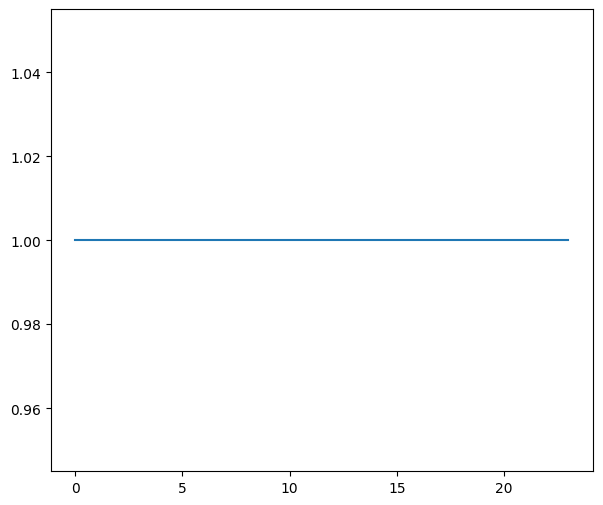

In [15]:
qaoa_profits = np.array(qaoa_profits)
bf_profits = np.array(bf_profits)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.plot(reps, qaoa_profits/bf_profits)

ax.set_xticks(reps)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax.set_xlabel('Repetitions', fontsize=FONTSIZE)
ax.set_ylabel('QAOA / Brute force profit', color='tab:blue', fontsize=FONTSIZE)
ax.set_title('QAOA accuracy', fontsize=FONTSIZE+2)
plt.show()